In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from datasets import load_dataset
from IPython.display import Audio
from torch.utils.data import DataLoader, TensorDataset

from cnn_model import CNNModel
from tqdm import tqdm

In [3]:
ds = load_dataset(
    path="data/urbansound8K",  # Points to the cloned repo root
    cache_dir="data/urbansound8K/cache",  # Cache directory for the dataset
)

In [4]:
metadata = pd.read_csv("data/urbansound8K/UrbanSound8K.csv")
print(metadata.fold.value_counts())
metadata.head()

fold
4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: count, dtype: int64


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
class_id_to_name = dict(zip(metadata['classID'], metadata['class']))
class_id_to_name

{3: 'dog_bark',
 2: 'children_playing',
 1: 'car_horn',
 0: 'air_conditioner',
 9: 'street_music',
 6: 'gun_shot',
 8: 'siren',
 5: 'engine_idling',
 7: 'jackhammer',
 4: 'drilling'}

In [6]:
ds['train'][0]

{'audio': {'path': '100032-3-0-0.wav',
  'array': array([-0.00454712, -0.00483704, -0.00460815, ..., -0.00065613,
         -0.00048828,  0.        ], shape=(14004,)),
  'sampling_rate': 44100},
 'slice_file_name': '100032-3-0-0.wav',
 'fsID': 100032,
 'start': 0.0,
 'end': 0.317551,
 'salience': 1,
 'fold': 5,
 'classID': 3,
 'class': 'dog_bark'}

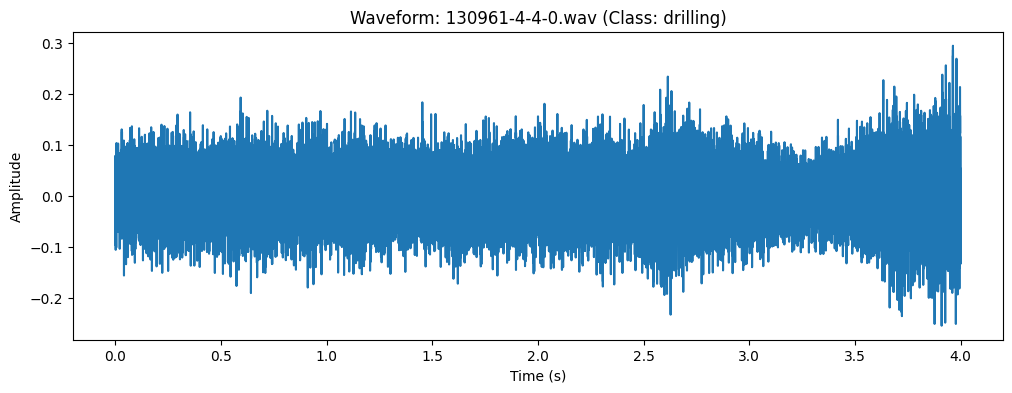

In [7]:
sample = ds['train'][1254]
waveform = sample['audio']['array']
sr = sample['audio']['sampling_rate']

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(waveform) / sr, num=len(waveform)), waveform)
plt.title(f"Waveform: {sample['slice_file_name']} (Class: {sample['class']})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Listen to the audio
display(Audio(waveform, rate=sr))

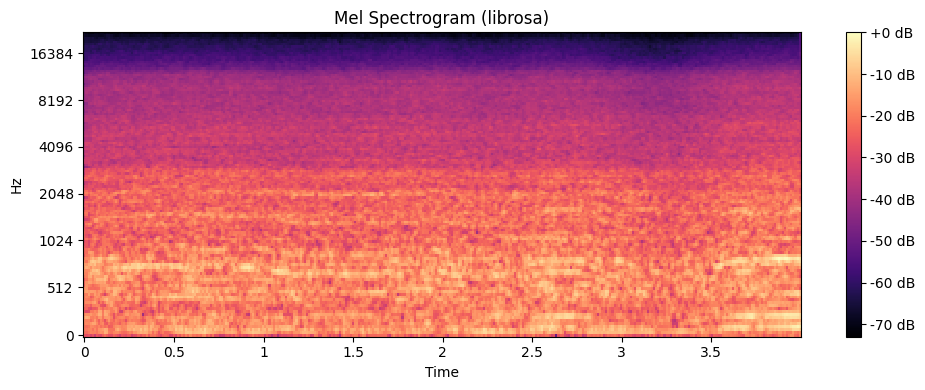

In [8]:
# Compute mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.title("Mel Spectrogram (librosa)")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

In [9]:
data = np.load("urbansound8k_mel.npz")

features = data["features"]
labels = data["labels"]
folds = data["folds"]
mean = data["mean"]
std = data["std"]

print(features.shape, labels.shape, folds.shape)
print("Before normalization:")
print("  features mean:", features.mean(), "std:", features.std())

features = (features - mean) / std

print("After normalization:")
print("  features mean:", features.mean(), "std:", features.std())

(8732, 1, 64, 1501) (8732,) (8732,)
Before normalization:
  features mean: -11.44289 std: 22.72535
After normalization:
  features mean: 3.4483312e-06 std: 0.99999887


In [10]:
num_epochs = 2
batch_size = 32
num_classes = 10

device = torch.device("cpu")

all_fold_accuracies = []

# Convert once, after loading and normalizing
features = torch.as_tensor(features, dtype=torch.float32)
labels = torch.as_tensor(labels, dtype=torch.long)
folds = torch.as_tensor(folds, dtype=torch.long)

for val_fold in range(1, 11):
    print(f"\n=== Fold {val_fold} ===")
    train_idx = folds != val_fold
    val_idx = folds == val_fold

    X_train, y_train = features[train_idx], labels[train_idx]
    X_val, y_val = features[val_idx], labels[val_idx]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

    model = CNNModel(num_classes=num_classes, input_channels=1, input_height=features.shape[2], input_width=features.shape[3]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        print(f"\n=== epoch: {epoch}")
        model.train()
        running_loss = 0.0
        for xb, yb in tqdm(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Training loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    print(f"Fold {val_fold} accuracy: {acc:.4f}")
    all_fold_accuracies.append(acc)

print("\n=== 10-Fold Cross-Validation Results ===")
print("Accuracies:", all_fold_accuracies)
print("Mean accuracy:", np.mean(all_fold_accuracies))
print("Std:", np.std(all_fold_accuracies))


=== Fold 1 ===



=== epoch: 0


100%|██████████| 246/246 [01:15<00:00,  3.26it/s]


Epoch 1/2 - Training loss: 1.9363

=== epoch: 1


100%|██████████| 246/246 [00:49<00:00,  4.97it/s]


Epoch 2/2 - Training loss: 1.2230
Fold 1 accuracy: 0.4227

=== Fold 2 ===

=== epoch: 0


100%|██████████| 246/246 [01:06<00:00,  3.72it/s]


Epoch 1/2 - Training loss: 1.5698

=== epoch: 1


100%|██████████| 246/246 [00:47<00:00,  5.18it/s]


Epoch 2/2 - Training loss: 1.1268
Fold 2 accuracy: 0.4516

=== Fold 3 ===

=== epoch: 0


100%|██████████| 244/244 [00:57<00:00,  4.23it/s]


Epoch 1/2 - Training loss: 1.8501

=== epoch: 1


100%|██████████| 244/244 [00:49<00:00,  4.92it/s]


Epoch 2/2 - Training loss: 1.1455
Fold 3 accuracy: 0.4497

=== Fold 4 ===

=== epoch: 0


100%|██████████| 242/242 [00:58<00:00,  4.14it/s]


Epoch 1/2 - Training loss: 1.8572

=== epoch: 1


100%|██████████| 242/242 [00:51<00:00,  4.73it/s]


Epoch 2/2 - Training loss: 1.1876
Fold 4 accuracy: 0.5545

=== Fold 5 ===

=== epoch: 0


100%|██████████| 244/244 [01:17<00:00,  3.15it/s]


Epoch 1/2 - Training loss: 1.7922

=== epoch: 1


100%|██████████| 244/244 [00:52<00:00,  4.67it/s]


Epoch 2/2 - Training loss: 1.2415
Fold 5 accuracy: 0.5363

=== Fold 6 ===

=== epoch: 0


100%|██████████| 248/248 [01:06<00:00,  3.74it/s]


Epoch 1/2 - Training loss: 1.8009

=== epoch: 1


100%|██████████| 248/248 [00:50<00:00,  4.89it/s]


Epoch 2/2 - Training loss: 1.1084
Fold 6 accuracy: 0.5018

=== Fold 7 ===

=== epoch: 0


100%|██████████| 247/247 [01:00<00:00,  4.08it/s]


Epoch 1/2 - Training loss: 1.9622

=== epoch: 1


100%|██████████| 247/247 [00:49<00:00,  5.00it/s]


Epoch 2/2 - Training loss: 1.1993
Fold 7 accuracy: 0.4141

=== Fold 8 ===

=== epoch: 0


100%|██████████| 248/248 [00:55<00:00,  4.50it/s]


Epoch 1/2 - Training loss: 1.5315

=== epoch: 1


100%|██████████| 248/248 [00:48<00:00,  5.06it/s]


Epoch 2/2 - Training loss: 1.1408
Fold 8 accuracy: 0.6253

=== Fold 9 ===

=== epoch: 0


100%|██████████| 248/248 [00:57<00:00,  4.29it/s]


Epoch 1/2 - Training loss: 2.0484

=== epoch: 1


100%|██████████| 248/248 [00:46<00:00,  5.38it/s]


Epoch 2/2 - Training loss: 1.2772
Fold 9 accuracy: 0.5159

=== Fold 10 ===

=== epoch: 0


100%|██████████| 247/247 [00:56<00:00,  4.40it/s]


Epoch 1/2 - Training loss: 1.6406

=== epoch: 1


100%|██████████| 247/247 [00:45<00:00,  5.48it/s]


Epoch 2/2 - Training loss: 1.1738
Fold 10 accuracy: 0.6069

=== 10-Fold Cross-Validation Results ===
Accuracies: [0.422680412371134, 0.45157657657657657, 0.44972972972972974, 0.5545454545454546, 0.5363247863247863, 0.5018226002430134, 0.41408114558472553, 0.6253101736972705, 0.5159313725490197, 0.6069295101553166]
Mean accuracy: 0.5078931761777026
Std: 0.07021229299250084


In [ ]:
torch.save(model.state_dict(), f"cnn_fold{val_fold}_state_dict.pth")

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

all_preds = []
all_targets = []

for val_fold in range(1, 11):
    # ...existing fold code...
    # During validation, collect predictions and targets
    fold_preds = []
    fold_targets = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_targets.extend(yb.cpu().numpy())
    all_preds.extend(fold_preds)
    all_targets.extend(fold_targets)

# Compute confusion matrix and per-class accuracy
cm = confusion_matrix(all_targets, all_preds)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("\n=== Per-Class Accuracy ===")
for class_id, acc in enumerate(per_class_acc):
    print(f"{class_id_to_name[class_id]}: {acc:.4f}")


=== Per-Class Accuracy ===
air_conditioner: 0.7000
car_horn: 0.4545
children_playing: 0.3400
dog_bark: 0.4700
drilling: 0.5200
engine_idling: 0.5161
gun_shot: 0.9375
jackhammer: 0.9688
siren: 0.4217
street_music: 0.8400
